<a href="https://colab.research.google.com/github/JeongJiHeon/ScoreDiffusionModel/blob/main/NCSN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision

import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output

In [ ]:
class Model(nn.Module):
    def __init__(self, device, L, sigma_min, sigma_max):
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L)).to(device = device)
        
        self.conv_model = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.InstanceNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.InstanceNorm2d(128),
            nn.GELU(),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.InstanceNorm2d(256),
            nn.GELU(),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.InstanceNorm2d(512),
            nn.GELU(),
            
            nn.Conv2d(512, 1, 3, 1, 1),
            
        )
        self.to(device = device)

    def loss_fn(self, x, idx=None):
        score, target, sigma = self.forward(x, idx=idx, get_target=True)

        losses = torch.square(score - target)
        losses = torch.mean(losses.reshape(losses.shape[0], -1), dim = -1) * sigma ** 2
        return torch.mean(losses)

        
    def forward(self, x, idx=None, get_target=False):
        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0), 1)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:, :, None, None]
            noise = torch.randn_like(x)
            x = x + noise * used_sigmas
            if get_target:
                target = - 1 / (used_sigmas ** 2) * noise
        else:
            used_sigmas = self.sigmas[idx]
        output = self.conv_model(x)
        output = output / used_sigmas

        return (output, target, used_sigmas) if get_target else output

In [ ]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, L, T, score_fn, device, eps = 1e-1):
        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.T = T
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        for _ in range(self.T):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_diffusion_step(self, x):
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        sample = torch.rand([sampling_number, 1, 28, 28]).to(device = self.device)
        sampling_list = []
        
        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)



In [ ]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [ ]:
def imshow(sample, sampling_number = 64):
    clear_output()
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = sample[row + col * row_number][0]
            
    show_sample = (show_sample - show_sample.min()) / (show_sample.max() - show_sample.min()) * 255
    show_sample = show_sample.astype(np.uint8)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

In [ ]:
eps = 2e-5
sigma_min = 0.01
sigma_max = 1

L = 10
T = 100

total_iteration = 100000
current_iteration = 0
display_iteration = 2000

transform = torchvision.transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root = './MNIST', train=True, download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 256, drop_last = True)


sampling_number = 4
device = torch.device('cuda')
only_final = True

dataiterator = iter(dataloader)

model = Model(device, L, sigma_min, sigma_max)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)

losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')


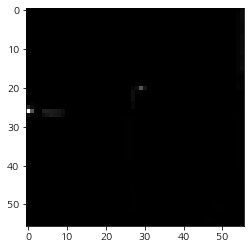

In [ ]:
while current_iteration != total_iteration:
    model.train()
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data[0].to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        imshow(sample, sampling_number)
        losses.reset()


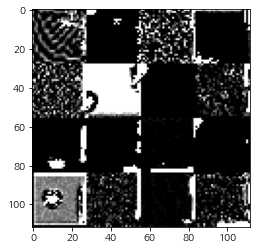

In [ ]:
sampling_number = 16
eps = 2e-4
T = 200
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
imshow(torch.clamp(sample, 0, 1), sampling_number)